# A neural probabilistic language model

![Bengio03](bengio03a-model.png)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
names = open('data/names.txt', 'r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
letters = sorted(list(set(''.join(names))))
SoS = '<.>'
letters = [SoS] + letters 
letter2index = {l:i for i, l in enumerate(letters)}
index2letter = {i:l for l, i in letter2index.items()}
print(index2letter)

{0: '<S>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [10]:
vocab_size = len(letter2index)
vocab_size

27

# building the dataset

In [9]:
block_size = 3
X, Y = [], []

for name in names[:3]:
    context = [letter2index[SoS]] * block_size
    print(name)
    for letter in (list(name) + [SoS]):
        idx = letter2index[letter]
        X.append(context)
        Y.append(idx)
        print(''.join(index2letter[i] for i in context), '--->', letter)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
X

emma
<S><S><S> ---> e
<S><S>e ---> m
<S>em ---> m
emm ---> a
mma ---> <S>
olivia
<S><S><S> ---> o
<S><S>o ---> l
<S>ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> <S>
ava
<S><S><S> ---> a
<S><S>a ---> v
<S>av ---> a
ava ---> <S>


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1]])

# Embedding

In [11]:
C = torch.randn((vocab_size, 2))

In [14]:
F.one_hot(torch.tensor(5), num_classes=vocab_size).float() @ C

tensor([ 0.0124, -0.6135])

In [15]:
C[5]

tensor([ 0.0124, -0.6135])

In [16]:
F.one_hot(torch.tensor([5, 6, 7]), num_classes=vocab_size).float() @ C

tensor([[ 0.0124, -0.6135],
        [-0.6207,  0.7795],
        [ 2.4797, -0.0936]])

In [17]:
C[torch.tensor([5, 6, 7])]

tensor([[ 0.0124, -0.6135],
        [-0.6207,  0.7795],
        [ 2.4797, -0.0936]])

In [22]:
X.shape, X[3]

(torch.Size([16, 3]), tensor([ 5, 13, 13]))

In [25]:
F.one_hot(X, num_classes=vocab_size).shape

torch.Size([16, 3, 27])

In [28]:
(F.one_hot(X, num_classes=vocab_size).float() @ C).shape

torch.Size([16, 3, 2])

In [29]:
C[X].shape

torch.Size([16, 3, 2])

In [39]:
X[14]

tensor([ 0,  1, 22])

In [40]:
C[X][14]

tensor([[ 0.0955,  1.2194],
        [-1.3639, -1.4684],
        [ 1.2063,  0.0492]])

In [41]:
C[[0,  1, 22]]

tensor([[ 0.0955,  1.2194],
        [-1.3639, -1.4684],
        [ 1.2063,  0.0492]])

In [42]:
embedded = C[X]
embedded.shape

torch.Size([16, 3, 2])

In [64]:
hidden_size = 100
W1 = torch.randn((6, hidden_size))
b1 = torch.randn((1, hidden_size))
b1.shape

torch.Size([1, 100])

In [51]:
torch.cat((embedded[:, 0, :], embedded[:, 1, :], embedded[:, 2, :]), dim=1).shape

torch.Size([16, 6])

In [52]:
torch.cat(embedded.unbind(dim=1), dim=1).shape

torch.Size([16, 6])

In [53]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [55]:
a.view(6, 3), a.view(2, 9)

(tensor([[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17]]))

In [62]:
embedded.view(-1, 6) == torch.cat(embedded.unbind(dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [67]:
hidden = torch.tanh(embedded.view(-1, 6) @ W1 + b1)
hidden

tensor([[-0.1156, -3.3405, -1.9725,  ...,  1.6886,  2.9538, -3.1325],
        [ 2.3423, -2.8731, -1.1609,  ..., -0.6045,  2.0455, -3.4211],
        [ 0.1777, -3.3069,  1.7019,  ...,  1.3497,  0.9319, -0.6496],
        ...,
        [ 3.3242, -1.9527, -0.4066,  ..., -2.8036,  0.6928, -1.0985],
        [-1.7031, -4.3965,  4.0040,  ...,  5.1107,  0.2566, -2.7036],
        [ 5.5390,  3.0133, -1.2980,  ..., -6.9448,  0.7509,  2.2817]])

In [68]:
hidden.shape

torch.Size([16, 100])

In [69]:
W2 = torch.randn((hidden_size, vocab_size))
b2 = torch.randn((1, vocab_size))

In [71]:
logits = hidden @ W2 + b2
logits.shape

torch.Size([16, 27])

In [72]:
counts = logits.exp()

In [73]:
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([16, 27])

In [74]:
probs.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [75]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0])

In [76]:
probs[torch.arange(16), Y]

tensor([8.9330e-19, 6.0664e-18, 3.3759e-28, 9.6421e-04, 9.7304e-20, 2.1453e-15,
        3.4513e-41, 9.8091e-45, 5.3779e-33, 2.3683e-13, 2.7507e-24, 1.2393e-17,
        2.6552e-03, 3.0912e-33, 2.8509e-20, 2.2569e-09])

In [77]:
nl_loss = - probs[torch.arange(16), Y].log().mean()
nl_loss

tensor(47.8569)

# Put together

In [80]:
block_size = 3
X, Y = [], []

for name in names[:5]:
    context = [letter2index[SoS]] * block_size
    for letter in (list(name) + [SoS]):
        idx = letter2index[letter]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [95]:
embedding_size = 2
hidden_size = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
b1 = torch.randn((1, hidden_size), generator=g)
W2 = torch.randn((hidden_size, vocab_size), generator=g)
b2 = torch.randn((1, vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [96]:
embedded = C[X]
hidden = torch.tanh(embedded.view(-1, block_size * embedding_size) @ W1 + b1)
logits = hidden @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
nl_loss = - probs[torch.arange(Y.size(0)), Y].log().mean()
nl_loss

tensor(17.7697, grad_fn=<NegBackward0>)

In [97]:
nl_loss = F.cross_entropy(logits, Y)
nl_loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

## Hints

* F.cross_entropy is more implemented
* backprop is more efficient
* F.cross_entropy deals better the exploded issue of logits.exp() with big value by substracting the max

In [98]:
for p in parameters:
    p.grad = None

nl_loss.backward()

lr = 0.1
for p in parameters:
    p.data -= lr * p.grad

# Training

In [102]:
block_size = 3
X, Y = [], []

for name in names:
    context = [letter2index[SoS]] * block_size
    for letter in (list(name) + [SoS]):
        idx = letter2index[letter]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [107]:
embedding_size = 2
hidden_size = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
b1 = torch.randn((1, hidden_size), generator=g)
W2 = torch.randn((hidden_size, vocab_size), generator=g)
b2 = torch.randn((1, vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [108]:
losses = []
n_epochs = 50

for epoch in range(n_epochs):
    embedded = C[X]
    hidden = torch.tanh(embedded.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y)

    for p in parameters:
        p.grad = None
    nl_loss.backward()
    losses.append(nl_loss.item())
    print(epoch, nl_loss.item())
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad

0 19.505229949951172
1 17.084495544433594
2 15.776532173156738
3 14.833337783813477
4 14.002594947814941
5 13.253251075744629
6 12.579911231994629
7 11.9830961227417
8 11.470490455627441
9 11.051854133605957
10 10.709585189819336
11 10.407631874084473
12 10.127808570861816
13 9.864364624023438
14 9.61450481414795
15 9.376440048217773
16 9.148946762084961
17 8.931112289428711
18 8.722232818603516
19 8.521751403808594
20 8.329230308532715
21 8.144328117370605
22 7.966794967651367
23 7.796453475952148
24 7.633190155029297
25 7.4769110679626465
26 7.3275251388549805
27 7.18488883972168
28 7.048795700073242
29 6.918957233428955
30 6.795023441314697
31 6.676608562469482
32 6.563323974609375
33 6.454793930053711
34 6.350673675537109
35 6.250648498535156
36 6.154436111450195
37 6.0617899894714355
38 5.97248649597168
39 5.886332035064697
40 5.803150653839111
41 5.722788333892822
42 5.6450982093811035
43 5.569950103759766
44 5.497217178344727
45 5.426784038543701
46 5.358539581298828
47 5.292378

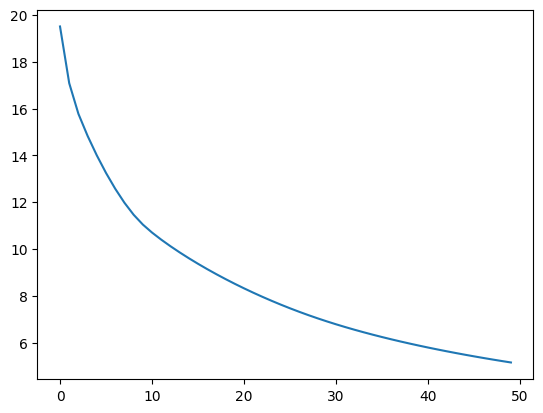

In [109]:
plt.plot(losses)

## Minibatch

In [110]:
torch.randint(0, 5, (10,))

tensor([3, 2, 3, 3, 1, 0, 4, 1, 4, 4])

In [112]:
batch_size = 32
batch_idx = torch.randint(0, X.size(0), (batch_size, ))
X[batch_idx].shape

torch.Size([32, 3])

In [114]:
losses = []
n_batches = 5000

for batch in range(n_batches):
    batch_idx = torch.randint(0, X.size(0), (batch_size, ))
    embedded = C[X[batch_idx]]
    hidden = torch.tanh(embedded.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y[batch_idx])

    for p in parameters:
        p.grad = None
    nl_loss.backward()
    losses.append(nl_loss.item())
    # print(epoch, nl_loss.item())
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad

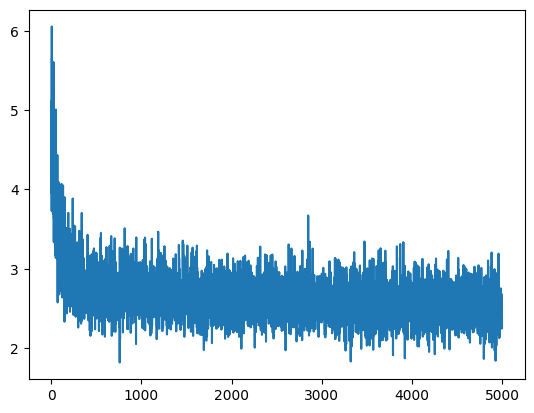

In [115]:
plt.plot(losses)

# Learning rate

In [170]:
def init_model(embedding_size, hidden_size, g):
    C = torch.randn((vocab_size, embedding_size), generator=g)
    W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
    b1 = torch.randn((1, hidden_size), generator=g)
    W2 = torch.randn((hidden_size, vocab_size), generator=g)
    b2 = torch.randn((1, vocab_size), generator=g)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True

    return {
        "C": C,
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "parameters": parameters
    }

def forward(model_dict, X_batch, Y_batch):
    C, W1, b1, W2, b2 = model_dict["C"], model_dict["W1"], model_dict["b1"], model_dict["W2"], model_dict["b2"]
    embedded = C[X_batch]
    hidden = torch.tanh(embedded.view(-1, W1.size(0)) @ W1 + b1)
    logits = hidden @ W2 + b2
    nl_loss = F.cross_entropy(logits, Y_batch)
    return nl_loss

def backprop(model_dict, loss, lr):
    parameters = model_dict["parameters"]
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    return loss.item()

def random_batch(X, Y, batch_size):
    batch_idx = torch.randint(0, X.size(0), (batch_size, ))
    return X[batch_idx], Y[batch_idx]


embedding_size = 2
hidden_size = 100
batch_size = 32
g = torch.Generator().manual_seed(2147483647)
model_dict = init_model(embedding_size, hidden_size, g)

In [171]:
losses = []
n_batches = 5000
lr = 0.1

for batch in range(n_batches):
    X_batch, Y_batch = random_batch(X, Y, batch_size)
    nl_loss = forward(model_dict, X_batch, Y_batch)
    loss_val = backprop(model_dict, nl_loss, lr=lr)
    losses.append(loss_val)


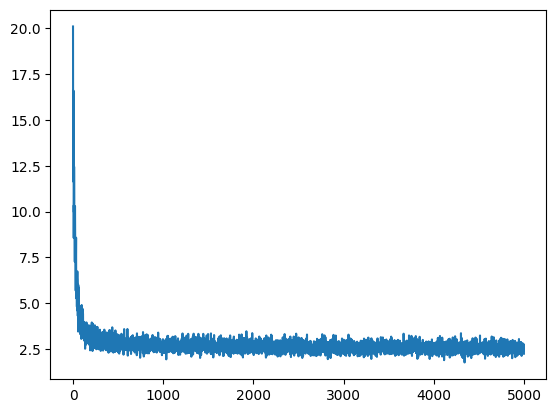

In [172]:
plt.plot(losses)

In [173]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [174]:
g = torch.Generator().manual_seed(2147483647)
model_dict = init_model(embedding_size, hidden_size, g)

losses = []
lri = []

for i, lr in enumerate(lrs):
    X_batch, Y_batch = random_batch(X, Y, batch_size)
    nl_loss = forward(model_dict, X_batch, Y_batch)
    loss_val = backprop(model_dict, nl_loss, lr=lr)
    losses.append(loss_val)
    lri.append(lre[i])


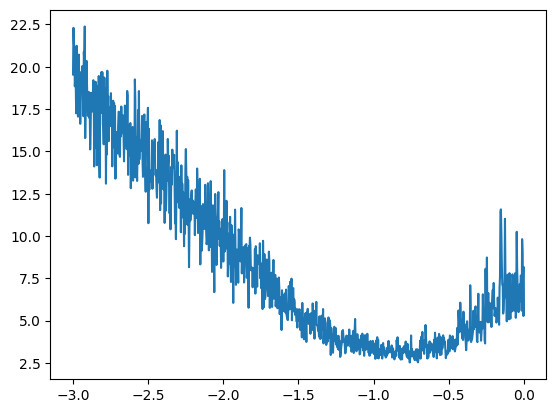

In [175]:
plt.plot(lri, losses)

# Train - Val - Test

In [176]:
import random

r_idx = list(range(5))
print(r_idx)
random.shuffle(r_idx)
print(r_idx)
torch.tensor([1, 2, 3, 4, 5])[r_idx]

[0, 1, 2, 3, 4]
[3, 0, 2, 1, 4]


tensor([4, 1, 3, 2, 5])

In [177]:
import random

def build_dataset(names):
    block_size = 3
    X, Y = [], []

    for name in names:
        context = [letter2index[SoS]] * block_size
        for letter in (list(name) + [SoS]):
            idx = letter2index[letter]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

def shuffle_data(X, Y):
    r_idx = list(range(X.size(0)))
    random.shuffle(r_idx)
    return X[r_idx], Y[r_idx]

random.seed(42)
X, Y = shuffle_data(*build_dataset(names))
n1 = int(0.8 * X.size(0))
n2 = int(0.9 * X.size(0))
X_train, Y_train = X[:n1], Y[:n1]
print("training:", X_train.shape, Y_train.shape)
X_val, Y_val = X[n1:n2], Y[n1:n2]
print("validation:", X_val.shape, Y_val.shape)
X_test, Y_test = X[n2:], Y[n2:]
print("test:", X_test.shape, Y_test.shape)


torch.Size([228146, 3]) torch.Size([228146])
training: torch.Size([182516, 3]) torch.Size([182516])
validation: torch.Size([22815, 3]) torch.Size([22815])
test: torch.Size([22815, 3]) torch.Size([22815])


In [178]:
X_train, Y_train = X[:n1], Y[:n1]
X_train.shape, Y_train.shape

(torch.Size([182516, 3]), torch.Size([182516]))

In [208]:
embedding_size = 2
hidden_size = 100
batch_size = 32
g = torch.Generator().manual_seed(2147483647)
model_dict = init_model(embedding_size, hidden_size, g)

In [194]:
list(range(0, X_train.size(0), batch_size))[-1], X_train.size(0)

(182496, 182516)

In [209]:
def train_model(model_dict, n_epochs):
    losses = []
    lr = 0.1

    for _ in range(n_epochs):
        epoch_loss = 0.0
        batch = 0
        for start in range(0, X_train.size(0), batch_size):
            batch_end = batch_size + start if batch_size + start < X_train.size(0) else X_train.size(0)
            X_batch, Y_batch = X_train[start:batch_end], Y_train[start:batch_end]
            # random_batch(X_train, Y_train, batch_size)
            nl_loss = forward(model_dict, X_batch, Y_batch)
            loss_val = backprop(model_dict, nl_loss, lr=lr)
            epoch_loss += loss_val
            batch += 1.0
        epoch_loss /= batch
        losses.append(epoch_loss)
    
    return model_dict, losses

model_dict, losses = train_model(model_dict, n_epochs=30)
print(losses[-2:])

[2.3071018933497505, 2.3051170328890627]


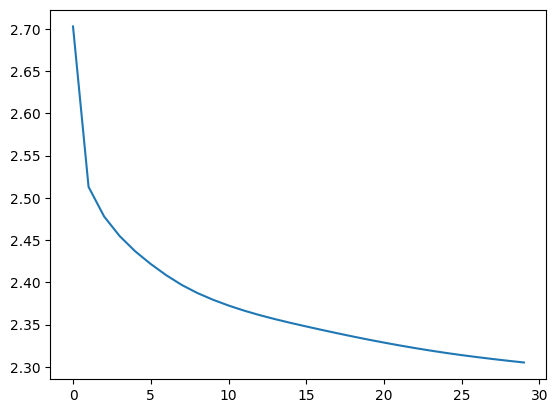

In [210]:
plt.plot(losses)

In [211]:
nl_loss = forward(model_dict, X_val, Y_val)
nl_loss.item()


2.3351926803588867

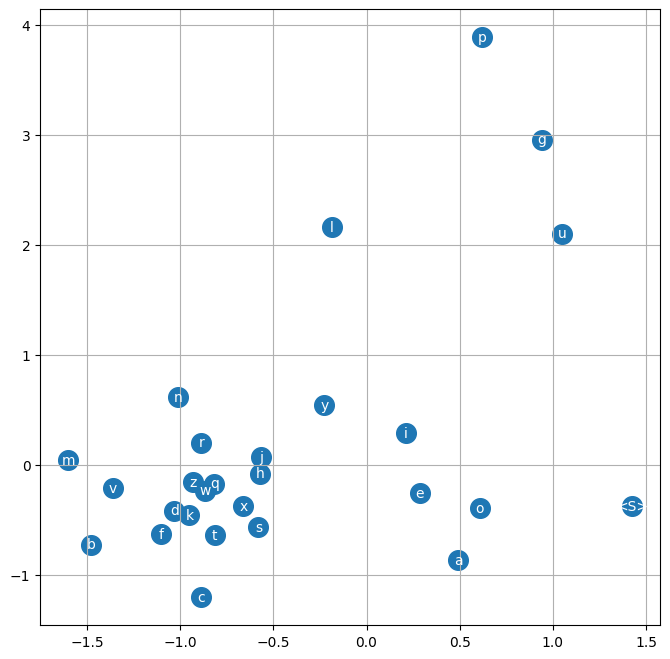

In [212]:
def plot_embedding(C):
    plt.figure(figsize=(8, 8))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
    for i in range(C.size(0)):
        plt.text(C[i, 0].item(), C[i, 1].item(), index2letter[i], ha='center', va='center', color='white')
    plt.grid('minor')

plot_embedding(model_dict["C"])

In [213]:
embedding_size = 10
hidden_size = 200
batch_size = 32

g = torch.Generator().manual_seed(2147483647)
model_dict = init_model(embedding_size, hidden_size, g)

model_dict, losses = train_model(model_dict, n_epochs=30)
print(losses[-2:])

[2.2641018869206415, 2.2617864421089435]


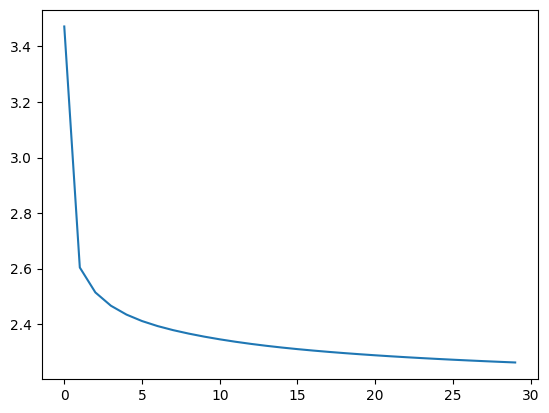

In [214]:
plt.plot(losses)

In [215]:
nl_loss = forward(model_dict, X_val, Y_val)
nl_loss.item()


2.3469247817993164

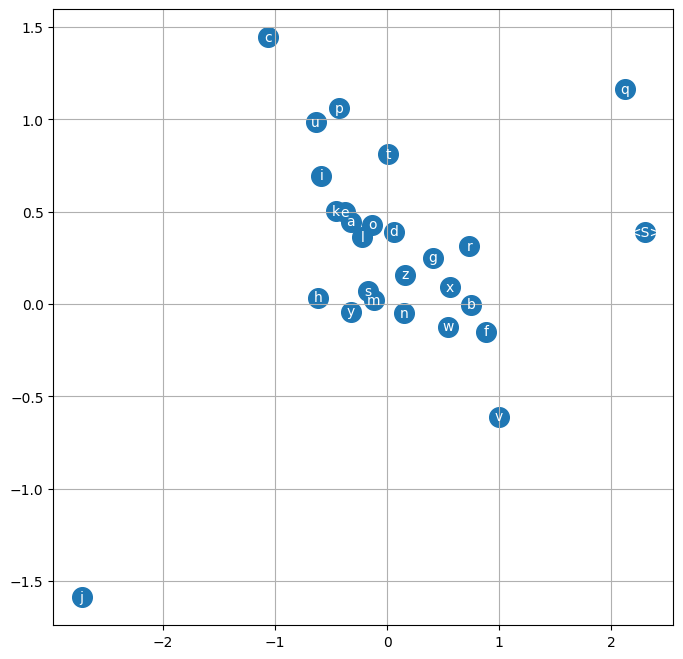

In [216]:
plot_embedding(model_dict["C"])

In [224]:
def sampling(model_dict, g, n_samples):
    C, W1, b1, W2, b2 = model_dict["C"], model_dict["W1"], model_dict["b1"], model_dict["W2"], model_dict["b2"]
    for _ in range(n_samples):
        outputs = []
        context = [letter2index[SoS]] * block_size
        while True:
            embedded = C[torch.tensor(context)]
            hidden = torch.tanh(embedded.view(-1, W1.size(0)) @ W1 + b1)
            logits = hidden @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            if index2letter[ix] == SoS:
                break
            outputs.append(index2letter[ix])
            context = context[1:] + [ix]
        print(''.join(outputs))


g = torch.Generator().manual_seed(2147483647 + 10)
sampling(model_dict, g, 10)


carlah
qui
havis
jmon
jesty
skanden
jazhnen
dan
rha
daqui
